(ch10:gnns)=
# Graph Neural Networks

Throughout this book, we have focused on ways in which you can represent and, if desired *conceptualize*, network-valued data that place it in a context in which you can apply many of the algorithms you are used to. 

For instance, in the case of the [spectral embedding](ch6:spectral), we devised techniques which allow you to take a network of nodes and edges, and construct a tabular array with which you can learn about using traditional techniques like $k$-means for [community detection](ch7:comm_detect), or other tasks of interest you might have. We learned how this representation had underpinnings in the [rdpg](ch5:rdpg), and how you could use this as a conceptual basis to assign explicit assumptions you might make about your network in order for you to do downstream statistical inference, such as if you want to [compare two networks](ch8:twosample). 

In this section and the next on [diffusion methods](ch10:diffusion), we are going to turn this approach somewhat on its head, and investigate approaches which, at face value, appear to fundamentally alter existing techniques which you already might know about, neural networks, to make them amenable to network-valued data directly. Let's get down to it.

## The drug discovery problem

In chemistry, a *molecule* is a group of atoms which are bonded together. If you haven't taken a chemistry course, you can think of an atom as a *building block*, and a *bond* as the *glue* that holds the molecule together. Every interaction you have with the world occurs through molecules; the water you drink, for instance, is a molecule consisting of hydrogen and oxygen, $H_20$, and the air you breathe consists most of molecules of nitrogen $N_2$, small amounts of oxygen $O_2$, and trace amounts of argon $Ar$ and carbon dioxide $CO_2$. In these formulas, the letters represent a particular atom, and the subscripts represent the number of these atoms in the molecule.

Without getting too deep into the chemistry, a fundamental problem for many pharmaceutical and chemistry investigations involves the analysis of molecules that might be useful for clinical purposes. A *clinically useful molecule* is a molecule which has properties which, for one reason or another, might make it beneficial for humans. For instance, if you. have ever had a headache, you have probably become familiar with a molecule $C_{13}H_{18}O_2$, or Ibuprofen (Advil).

Many of the drugs that we are familiar with on an everyday basis have, it turns out, been discovered totally by accident. For a laugh, we'd encourage you to check out the discovery of [penicillin](https://en.wikipedia.org/wiki/Alexander_Fleming#Discovery_of_penicillin), which is a family of molecules having a core structure of $C_9H_{11}N_2O_4S$. 

Unfortunately, coming across all of these "happy accident" molecules has become more and more infrequent as pharmaceuticals have progressed. When a given condition is identified that a pharmacologist decides to attempt to devise a treatment for, they often must proceed facing several enormous hurdles for candidate molecules. The molecules must be:
1. non-toxic to humans,
2. an appropriate size,
3. be readily absorbed by humans, and
4. able to address the condition of interest.

Achieving all of these aims is extremely difficult, and extremely risky in terms of time, labor, and most of all potential risk to human participants in drug trials. Determining definitive, or at least suggestive, evidence that the molecule will achieve any or all of these conditions *before* running live human tests can save the company billions of dollars and can save participants in drug trials unnecessary exposure to harm.

Running laboratory tests to screen these molecules is an expensive, time-consuming, and skilled labor-intensive process: what are the companies left to do?

Many drug companies utilize virtual screening methods in which computational methods are used to quickly search large libraries of molecules to filter ones with the desirable properties. Success in virtual screening methods are determined by the accuracy and speed of the computational approach. For instance, molecular dynamics simulates the physical movement of each atom and particle, thus providing the most accurate calculations of molecular properties, but requires an intractable number of numerical calculations that makes it infeasible to use in practice. Instead, methods have been built around succint 2D representations of molecules, further compressed in 1D [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) strings (Simplified molecular-input line-entry system), that summarize the structural relationships between different atoms through the chemical bonds connecting them. These $1D$ strings are known as *fingerprints* for the molecules.

![title](Images/molecule_repr.png)

Using SMILES, practioners have built statistical models to estimate correlations between SMILES and different molecular properties. These traditional methods have relied on building hand-crafted features derived from SMILES and optimizing simplistic statistical models to predict molecular properties from fingerprints of the molecules. 

This too, however, is extremely labor intensive and, most importantly, requires direct human intervention to decipher the features used for statistical learning. With some clever manipulation, scientists have identified an ingenius approach to turn molecular screening into a network learning problem.

### Obtaining a network from a molecule

In our initial description of a molecule, we described that a molecule was just a group of atoms which are bonded together. How can we conceptualize this as a network?

If we think of the atoms of the molecule as the nodes of the network, and the bonds as the edges, this problem is extremely straightforward. Let's see how this would work with a single molecule of water. Remember that water has the molecular formula $H_2O$, which means that it is two hydrogen atoms, and one oxygen atom. The molecular structure of water is that the oxygen atom basically sits in the middle, and the hydrogens hang off the side. We can turn this molecular structure into a network like this:

```{figure} Images/water_molecule.png
---
align: center
name: water-molecule
---
(A) A water molecule's molecular structure. This structure has been determined directly through experimentation. (B) The water molecule, but as a network with a layout view. The atoms (oxygen and two hydrogens) become the nodes of the network, and the bonds between the oxygen atom and the hydrogens become the edges. (C) The network as an adjacency matrix. The fingerprint for water is the string $O$.
```

Given a fingerprint (the SMILES string), this molecular structure, and consequently the network and the adjacency matrix, are fully determined. The inverse is also true: given a network and the other attributes of the atomic structure, the fingerprint can be determined. Implicitly, computational strategies which produce desirable representations of the fingerprints produce a desirable representation for the network itself.

### Our network learning problem

For this section, we will focus our attention on the first hurdle faced by pharmacoligists. Provided a SMILES fingerprint for a molecule, we would like to determine whether the molecule is toxic or non-toxic.

## Preprocessing SMILES fingerprints

We will be using one of the datasets packaged in [MoleculeNet](https://moleculenet.org/). PyTorch Geometric (PyG) provides a convenient module to access it. We first import the module `MoleculeNet` then extract the `ClinTox` dataset. The dataset has a total of 1478 molecules labeled with their presence or absence of toxicity -- determined from clinical trials done by the Food & Drug association (FDA). Since this is a binary classification task, we observe there are two classes.

In [1]:
from torch_geometric.datasets import MoleculeNet

dataset = MoleculeNet(root='data/clintox', name='ClinTox')
print(f'Dataset: {dataset}\nNumber of molecules/graphs: {len(dataset)}\nNumber of classes: {dataset.num_classes}')

Dataset: ClinTox(1478)
Number of molecules/graphs: 1478
Number of classes: 2


Let's look at a few molecules to understand their graph structure. Each molecule has a known 3D structure and an associated SMILES string. We pick out two arbitrary molecules from the dataset, and take a look first at their SMILES string:

In [2]:
mols = dataset[26], dataset[83]
[print(m.smiles) for m in mols];

C([C@@H]1[C@H]([C@@H]([C@H](C(=O)O1)O)O)O)O
C1[C@@H]([C@H](O[C@H]1N2C=NC(=NC2=O)N)CO)O


Using these smiles, we can determine the molecular structure with `rdkit`, and can plot the resulting molecule as a graph. Remember that in the graph, individual atoms form the nodes of the network, and the bonds form the edges. While some of the specific edges have strange shapes (such as dotted lines, triangular structures, or "doubled bonds"), you can ignore these details for now as they require a bit more in-depth knowledge of organic chemistry to appreciate:

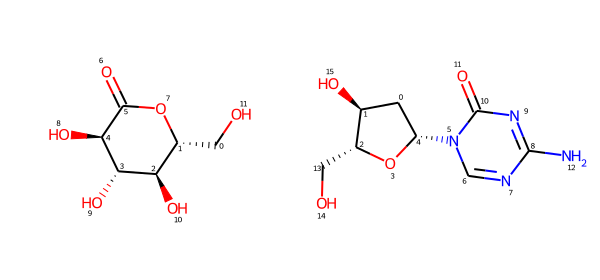

In [3]:
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

smiles = [Chem.MolFromSmiles(m.smiles) for m in mols]
d2d = rdMolDraw2D.MolDraw2DSVG(600,280,300,280)
d2d.drawOptions().addAtomIndices = True
d2d.DrawMolecules(smiles)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

The networks each have a different number of nodes (atoms). Further, each node has a number which uniquely identifies that node in the molecule. These molecules have been analyzed with cheminformatics software, [RDkit](https://www.rdkit.org/), and also come with a set of node attributes for descriptive characteristics of that node in the particular molecule. While these node attributes are not relevant for our tutorial, they have substantial real-world applications to optimize predictive accuracy. Let's take a look at the number of atoms and the number of atomic features now:

In [4]:
for i,m in enumerate(mols):
    print(f'Molecule {i+1}: Number of atoms={m.x.shape[0]}, Features per atom={m.x.shape[1]}')

Molecule 1: Number of atoms=12, Features per atom=9
Molecule 2: Number of atoms=16, Features per atom=9


As we discussed above, the edges of the network are the bonds between different pairs of atoms (the nodes). Using the SMILE fingerprint, we can also obtain information of the bonds of the network. Let's take a look at the indices of the bonds, shown below:

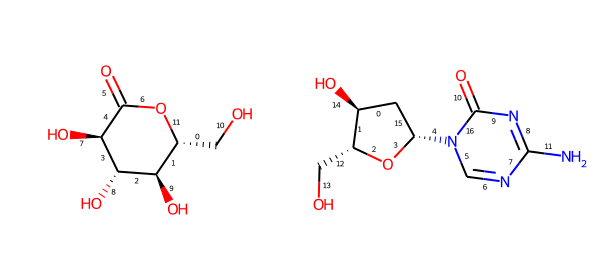

In [5]:
d2d = rdMolDraw2D.MolDraw2DSVG(600,280,300,280)
d2d.drawOptions().addBondIndices = True
d2d.DrawMolecules(smiles)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

Unlike many of the networks we have seen in examples so far, molecular networks tend to be, especially for larger molecules (molecules with more nodes, or atoms) extremely sparse. A **sparse network** is a network which has far fewer edges than the maximum number of possible edges. In smaller networks, this is a rather irrelevant consideration. Remember that the adjacency matrix has, for a simple network, $\binom n 2 = \frac{1}{2}n(n - 1)$ possible edges. So, if we store the entire adjacency matrix, we need to keep track of $\frac{1}{2}n (n - 1)$ entries. 

In a sparse network, the total number of edges might be considerably less than this. Remember that an edge is indexed by two nodes, so if two times the number of edges is less than $\binom n 2$, we can save a lot of space by exclusively saving the node pairs for each edge. This is the concept underlying an *edgelist*, which is as the name suggests, a list of edges. Instead of saving the *entire* adjacency matrix, what we do is we save *only* the edges, and then construct the adjacency matrix *only when we need it* from the edges! 

When you have a *sparse network*, and consequently a *sparse adjacency matrix*, you can even perform many matrix computations without ever having to construct the (potentially large) adjacency matrix in its entirety. This is the concept underlying [sparse matrices](https://en.wikipedia.org/wiki/Sparse_matrix), and many numerical libraries such as [scipy](https://docs.scipy.org/doc/scipy/reference/sparse.html) and [torch sparse arrays](https://pytorch.org/docs/stable/sparse.html) (which we are leveraging here) have special matrix routines which run a *lot* faster, and use a *lot* less space, when the network is extremely sparse.

With this in mind, when we look through the dataset, we need to keep in mind that the network is stored using this sparse edgelist format. To build the adjacency matrix so that we can visualize it using the traditional heatmap, we need to first construct the adjacency matrix from the edgelist, which is what we do below:

In [6]:
import numpy as np

_process = lambda x: [e[0] for e in np.split(x, 2)]
def A_from_edgelist(molecule):
    """
    A function that takes molecules, and produces an adjacency matrix.
    """
    # the number of nodes is the number of atoms (rows of .x attribute)
    n = molecule.x.shape[0]
    # the adjacency matrix is n x n
    A = np.zeros((n, n))
    edgelist = m.edge_index.numpy()
    # loop over the edges e_k, and for each edge, unpack the 
    # nodes that are incident it. for this corresponding pair of nodes, 
    # change the adjacency matrix entry to 1
    for e_k, (i, j) in enumerate(zip(*_process(edgelist))):
        A[i, j] = 1
    return A

Now that we have a function that will produce the corresponding adjacency matrices, we can produce the heatmaps of the adjacency matrices:

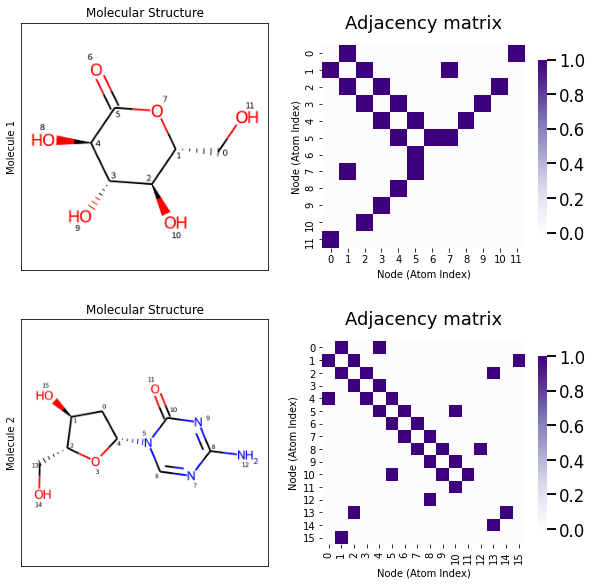

In [7]:
from matplotlib import pyplot as plt
import cairosvg
from PIL import Image
from io import BytesIO
from graphbook_code import heatmap

fig, axs = plt.subplots(2, len(mols), gridspec_kw={"width_ratios" : [1, 1]}, figsize=(10, 10))
for m_i, m in enumerate(mols):
    A = A_from_edgelist(m)
    atoms = [i for i in range(A.shape[0])]
    ax = heatmap(A, ax=axs[m_i, 1], title='Adjacency matrix',
            xticklabels=atoms, yticklabels=atoms)
    ax.set_xlabel("Node (Atom Index)")
    ax.set_ylabel("Node (Atom Index)")
    d2d = rdMolDraw2D.MolDraw2DSVG(280,280,280,280)
    d2d.drawOptions().addAtomIndices = True
    d2d.DrawMolecule(Chem.MolFromSmiles(m.smiles))
    d2d.FinishDrawing()
    svg = d2d.GetDrawingText().replace('svg:','')
    img = cairosvg.svg2png(svg)
    img = Image.open(BytesIO(img))
    axs[m_i, 0].imshow(img)
    axs[m_i, 0].get_xaxis().set_ticks([])
    axs[m_i, 0].get_yaxis().set_ticks([])
    axs[m_i, 0].set_ylabel(f"Molecule {m_i + 1}")
    axs[m_i, 0].set_title("Molecular Structure")

Let's take a look at this just to verify we can confirm what is going on. Notice that in Molecule $1$, that an Oxygen atom (index $7$) is bonded to two Carbon atoms (the "points" of the hexagon are Carbon atoms), which each have indices $1$ and $5$ respectively. When we look at the adjaceny matrix, looking at the row corresponding to atom index $7$ shows that it is connected to atom indices $1$ and $5$, as desired. As an exercise, you can continue this process for all of the atoms in the molecule until you are convinced that you understand what's going on!

So, now the take-home message; why did we choose these two molecules? Does anything look obvious to you, as a machine learning specialist with network expertise, about these two molecules?

Well, quite simply, the first one is non-toxic, whereas the second one is quite toxic! To know this, you would probably need to be somewhat of an expert in organic chemistry, which for the majority of machine learning experts, probably isn't the case!

Despite the fact that you might not have background in organic chemistry, you can still be of *extreme* use to pharmacologists: it turns out that, even though you don't know a heck of a lot about either of these two molecules, nor perhaps even the field, you do know a lot about classifying items! Let's see if we can borrow some techniques from machine learning to learn about these molecules.

## Graph neural networks (GNNs)

At this point, we've done a decent exploration into the SMILES strings, and hopefully we've convinced you that, given the SMILES string, we can recover either the molecular structure in its entirety or an underlying adjacency matrix. Now it's time for the fun part. As it turns out, using *only* this adjacency matrix, you can do a pretty good job of identifying what, to my eyes anyways, is a completely opaque task: determining whether a molecule is toxic or non-toxic. We'll show you how using an approach you may have come across before in machine learning, known as a *neural network*. If you are unfamiliar with neural networks and the basic mathematics which are used to describe them, or if you need a quick refresher, we would recommend you check out Aurelien Geron's book, [Hands On Machine Learning](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/ref=asc_df_1492032646/?tag=hyprod-20&linkCode=df0&hvadid=385599638286&hvpos=&hvnetw=g&hvrand=6554720435744381928&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9007894&hvtargid=pla-523968811896&psc=1&tag=&ref=&adgrpid=79288120515&hvpone=&hvptwo=&hvadid=385599638286&hvpos=&hvnetw=g&hvrand=6554720435744381928&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9007894&hvtargid=pla-523968811896), which has an extensive discussion of them.

In this task, we have several problems which fundamentally distinguish this task from many of the approaches we have seen before. When we learned representations for network-valued data previously, we assumed that, as the investigator, you probably had a decent knowledge of the structure of your data ahead of time, and which assumptions might be sensible to pick out. When this was the case, you could decipher [statistical models](ch5) which might be reasonably sensible for your data (the assumptions might not be perfect, but good enough for the purposes of your investigation), and use these statistical models to facilitate downstream statistical inference tasks you want to learn about. 

When dealing with expansive molecular networks (the two molecules we picked out were rather tiny, but molecules related to drug discovery can be enormous, with dozens to thousands of atoms), we have a few problems that arise. In particular, it is often extremely unclear how to construct a direct statistical model that can be feasibly optimized or learned, as identifying the core features you want to capture with the statistical model for unseen molecules (or whatever your underlying networks represent) can be arduous, time consuming, and require domain expertise that you just might not have. A practical solution to this hurdle might be to use Graph Neural Networks (GNNs). A graph neural network is just a neural network, but modified for use with graph (or network)-valued data.

GNNs have two desirable properties that can help us to overcome some of these hurdles:

### GNNs are universal approximators

When you have a task of interest in mind, assuming that your data is informative for that task, there are features or aspects of your data (which might be extremely convoluted) that you can "tease out" which will give you the best possible information for your question of interest. 

These features might be simple; for instance, to classify a molecule, the presence of at most $5$ bonds might be the definitive feature that makes a molecule toxic or non-toxic. Any molecule with more than $5$ bonds could be toxic, and any molecule with less than $5$ bonds could be non-toxic.

However, in practice (and in this task), the features are not nearly that simple, nor completely understood even by the most pre-eminent experts in organic chemistry, and this problem permeates to many other fields other than just pharmacology. 

GNNs provide a framework for constructing universal approximators for network-valued data. A *universal approximator* has a fairly complicated definition, so we won't define it formally here. But basically the idea is that, *whatever* the relationship between the data (the network) and the outcome of interest (in this case, toxic or non-toxic) happens to be, no matter how complicated or convoluted it is, a properly chosen GNN is *always capable* of closely finding the relationship. The caveat is that the meaning of "close" is contingent on the number of training samples. Although you probably have come across the term training data before, we'll define it formally for you here: **training data** is data which you will use to train an algorithm to predict the outcome you intend to study. The idea is that, if the network has enough free parameters (a function of the number of *nodes* and *edges* in the neural network, not to be confused with the number of nodes/edges in the networks that we are studying)  This is extremely appealing in fields in which we domain expertise can't help us too much, and where we have tons of training data. 

In this case, there are hundreds of thousands of molecules that have been extensively and exhaustively studied by pharmacologists for toxicity, so we have a substantial backlog of data where we know ahead of time whether the molecule is toxic or not. Further, even to trained scientists, as the molecule size grows, determining toxicity can be difficult and certainly not immediate as it can be for a properly trained neural network.

### GNNs are easy and efficient to optimize

Once you have an enormous volume of training data, you might be extremely concerned about how well you might be able to actually train up this neural network. Fortunately, there is plenty of help out there. A plethora of software libraries have been built to allow for neural network training and optimization. The success of neural networks is closely tied with the advent of special computer hardware, Graphical Processing Units (GPUs), that greatly accelerate and scale numerical calculations. GNNs are widely used in practice because they can scale to very large and high-dimensional datasets due to the tight coupling of engineering progress/technical advances in GPU performance and mathematical theory.

## How do GNNs work for drug discovery?

For drug discovery, a pre-eminent technique for the construction of neural networks is to construct a message passing neural network (MPNN). This approach leverages a hybrid of the [bag of nodes](ch4:representations) and the [bag of networks](ch4:representations) type of approaches, in which we search for a *latent* (unknown) embedding for each node in a given molecule network, and then we use the resulting embedding of the nodes in the molecule of the network to identify a *latent* embedding for the entire molecule itself. In this investigation, we will assume that we have $M$ total training networks and $M'$ testing (validation) networks, where each network $m$ (a single molecule) has $n_m$ nodes in the network. 

You will notice that there is a caveat from many of the multi-network examples we have studied to date: the number of nodes, $n_m$, is *not* going to necessarily be constant across the networks: each molecule can, and *will* tend to have differing numbers of atoms of which they are comprised. The way that this hurdle is overcome for MPNNs is the message passing procedure. 

If you want a more rigorous description of what's going on with the message passing procedure, please check out the appendix section, [message passing neural networks](app:ch14:mpnn), which details the particularities of the techniques we are looking at here. The descriptions below give a general overview of how GNNs are used for arbitrary network-valued data, so it is important to realize that the specific implementation we gave could be interchanged with other "pieces" for use with data from other domains of network science.

### GNN training

Training deep learning and optimization-focused algorithms have a bit of a unique approach from other domains of machine learning. Rather than just separating the data into training and testing sets outright, the training set tends to be further segmented into a thing, called an *epoch*, which represents a random shuffling of the networks in the dataset.

Within a single epoch, we will further segment the dataset into $B$ batches. Each of the $B$ batches are sampled, *uniformly* in size and *without* replacement (each training network appears in *exactly* one batch across an epoch), from the training set. We will assume that each batch has $M_b$ networks, where $M_b = \frac{M}{B}$ is the number of networks in each batch. The purpose of separating the dataset into multiple batches is that, as we mentioned, neural networks tend to perform best with large numbers of data samples. With so many samples, it is often the case that you won't necessarily be able to seamlessly analyze all of these samples in a computationally feasible way (e.g., in *parallel*) if you look at all of them simultaneously. 

For the purposes of this experiment, we will assume that $M$ is divisible by the number of batches chosen, but this might not always necessarily be the case. However, it is fine to have one batch be slightly different in size from the others. Overall, this kind of looks like this:

```{figure} ./Images/nn_epoch.png
---
align: center
name: dataset
---
The dataset is initially split into a training and a testing set. The training set is further randomly reordered and then split into $B$ equally-sized batches within each of $R$ total epochs. Each batch contains a unique set of molecules.
```

It's pretty straightforward to split a dataset into training and testing sets, and then further sample the training set into epochs divided batches with `torch`. Let's see how we can do this below. First, we split the dataset into training and testing sets:

In [20]:
import torch
# for notebook reproducibility
torch.manual_seed(12345)

dataset = dataset.shuffle()

train_dataset = dataset[:-150]
test_dataset = dataset[-150:]

print(f'Number of training networks: {len(train_dataset)}')
print(f'Number of test networks: {len(test_dataset)}')

Number of training networks: 1328
Number of test networks: 150


Data(x=[33, 9], edge_index=[2, 72], edge_attr=[72, 3], y=[1, 2], smiles='C[C@@H]1[C@@H]2[C@H](C(=O)N2C(=C1S[C@H]3C[C@H]([NH2+]C3)C(=O)Nc4cccc(c4)C(=O)[O-])C(=O)[O-])[C@@H](C)O')

In [21]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of networks in the current batch: {data.num_graphs}')
    print(data)
    break

Step 1:
Number of networks in the current batch: 64
DataBatch(x=[1523, 9], edge_index=[2, 3228], edge_attr=[3228, 3], y=[64, 2], smiles=[64], batch=[1523], ptr=[65])


We'll work through the GNN training at an extremely high level next. 

#### The forward pass

The forward pass begins on a single batch $b$, of which there are $B$ total. We assume that there are $M_b$ molecules in total in batch $b$.

For a given network $m$, we begin by passing the network through the graph convolutional layer, denoted by $\text{GCN}\left(\text{Network }m\right)$, shown in {numref}`gnn`(A). This GCN has parameters $\theta_b$ and $\phi_b$, which are just the weights for the particular GCN that will be used for batch $b$. The graph convolutional layer produces embeddings for each of the $n_m$ nodes, which is a $d$-dimensional vector. In this way, we end up with an *embedding matrix* $X^{(m)}$, which has $n_m$ nodes and $d$ latent dimensions. This is extremely conceptually similar to what happens with an [omnibus embedding](ch6:multinet:omni), but tends to allow greater flexibility in the characteristics of the embeddings which you end up with. The caveat is that, when the number of training samples are smaller, the restrictions of the omnibus embedding can be advantageous to avoid overfitting.

Given the node embedding matrix $X^{(m)}$, we then pass to a readout layer, denoted by Readout(X), shown in {numref}`gnn`(B). This readout layer has parameters $\rho_b$, which indicate how the $n_m$ separate node embeddings should be aggregated by the readout algorithm chosen. The readout layer produces a single embedding for the entire network, which is an $f$-dimensional vector denoted $\vec r^{(m)}$.

Given the network embedding $\vec r^{(m)}$, we then are ready to make a prediction for our network which is denoted by $\text{Predict}\left(\vec r^{(m)}\right)$, shown in {numref}`gnn`(C). The prediction function has parameters $\beta_b$, and in the simplest case (binary) like we have here, is simply a perceptron. The perceptron simply produces a weighted sum of all $f$ dimensions (with weights denoted by the paramter set $\beta_b$), and if the weighted sum exceeds a particular value (the *offset*), predicts that the network is in class $1$. Otherwise, it predicts that the network is in class $0$.

```{figure} ./Images/gnn.png
---
align: center
name: gnn
---
A molecule $m$ has a predicted label computed, using a graph convolutional layer, a readout layer, and a prediction layer.
```

We can define this using `torch` as follows:

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes, bias=False)

    def forward(self, x, edge_index, batch):

        # 1. Obtain node embeddings via convolutional layers
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer to produce network embedding
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a prediction classifier to the network embedding
        x = self.lin(x)
        
        return x
    
model = GCN(hidden_channels=64)
print(model)

The forward pass is applied to all of the molecules in a single batch, as shown in {numref}`forwardpass`(A). The pass is applied to all networks with *the same* parameters $(\theta_b, \phi_b, \rho_b, \beta_b)$ for a given batch, as indicated by {numref}`forwardpass`(B). Once predictions are made for all $M_b$ molecules, the prediction loss is computed, which is a scalar quantity that we seek to minimize. The prediction loss is denoted by $\text{Loss}\left(\hat y_1, ..., \hat y_{M_b}\right)$. Inherently, since the predictions used to compute the loss are all produced by the particular parameters used for the forward pass $(\theta_b, \phi_b, \rho_b, \beta_b)$, the loss is also a function of the parameters. 

```{figure} ./Images/forward_pass.png
---
align: center
name: forwardpass
---
A single pass through the graph neural network for the $M_b$ molecules.
```

```{admonition} Message Passing Neural Networks (MPNNs)

```

#### The backward pass

The last sentence we wrote in there is the key with neural networks: the predictions (and consequently, the loss) produced for a given batch, $b$, are inherently a function of the parameters we used in the forward pass $(\theta_b, \phi_b, \rho_b, \beta_b)$. When the convolutional layer, the readout layer, and the prediction layers are chosen using *differentiable* functions (meaning, we can compute the *derivative* with respect to the parameters), we can actually use this differentiability in conjunction with the particular loss function we employed (in this case, the cross-entropy loss) to determine how the loss function behaves when we change the parameters slightly. This is done by taking the derivative of the loss, denoted $\frac{\partial \text{Loss}}{\partial x}$, where $x$ just denotes the parameter that you are interested in at a given point in time. 

By using a number of ultra convenient rules of calculus, we can gradually use these derivatives with respect to each of the paramters and their *current values* to make small changes, or *updates*, to their values. This is the concept underlying [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent), which plays an important role in optimization throughout many aspects of computational science. Another reason why we use batches which are a random subset of the dataset is that, when combined with gradient descent, the parameters you end up with from gradient descent tend to, in the theoretical sense, behave very similarly to the parameters you would end up with if you instead just looked at the entire epoch.

When we update the parameters, we end up with a new set of parameters $(\theta_{b + 1}, \phi_{b + 1}, \rho_{b + 1}, \beta_{b + 1})$.

#### Rinse and repeat for the entire epoch

After we complete a forward and backward pass, we just repeat this process, again and again for each batch, until we get to the end of an epoch. This is illustrated in {numref}`epoch_compute`(A). When we get to the end of an epoch, we use the held out testing data, which the neural network was *not* computed using, to estimate the testing accuracy, with the parameters we obtain from the *final* backwards pass. The testing data is fed through the neural network forwards, and then we compute the testing accuracy, as illustrated in {numref}`epoch_compute`(B).


```{figure} ./Images/epoch_compute.png
---
align: center
name: epoch_compute
---
We repeat forward and backwards passes over each batch within the epoch, starting with parameters $(\theta_i, \phi_i, \rho_i, \beta_i)$, and ultimately ending up with parameters $(\theta_{i + B}, \phi_{i + B}, \rho_{i + B}, \beta_{i + B})$. The parameters from the final batch are assessed on the held-out testing set.
```

## Putting it all together

Now that we understand each piece individually, we are ready to look at what the whole process looks like. The dataset is randomly reordered into $R$ epochs, and then each epoch is split into $B$ batches. The parameters from the preceding epoch (or, if this is the first epoch, just initialization parameters) begin the first forward pass, and then forwards and backwards passes are alternated with the parameters updated accordingly after each batch is passed through. At the end of the epoch, the resulting parameters {numref}`full_process`(C) are analyzed with the held-out testing data are used for validation. The parameters from the epoch with the best performance on the testing data are ultimately returned as the trained model parameters.

```{figure} ./Images/full_process.png
---
align: center
name: full_process
---
The entire procedure is applied to the entire dataset. The training data is split into $R$ epochs, and each epoch iterates forwards and backwards passes over the batches to update the parameters. When we get to the end of the last batch at the end of an epoch, we use the parameters and the GNN with the held-out testing data to assess performance. The best performing parameters across all epochs are returned as the trained model.
```

In [ ]:
# from IPython.display import Javascript
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        
        out = model(data.x.float(), data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y[:, 0].long())  # Compute the loss.
        
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
        model.eval()

        correct = 0
        for data in loader:  # Iterate in batches over the training/test dataset.
            out = model(data.x.float(), data.edge_index, data.batch)  
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y[:, 0]).sum())  # Check against ground-truth labels.
        return correct / len(loader.dataset)  # Derive ratio of correct predictions.

R = 10  # number of epochs
for epoch in range(0, R):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')